# Teoría de Markovitz aplicada a Portfolio Managment

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [35]:
df_preciosPort=pd.read_excel(r"C:\Users\AN012491\Desktop\PreciosPortf.xlsx","Precios",index_col=0)
rends=df_preciosPort.pct_change().fillna(0)

### Funciones de rendimiento esperado y volatilidad de un portafolio

In [10]:
def mean_port(w,r):
    Ep=(r.mean()@w)*252
    return Ep

def ds_port(w,r):
    Sp=np.sqrt(w.T@(r.cov()*252)@w)
    return Sp

## Graficación

### Simulación de pesos 

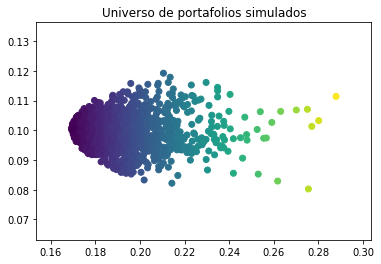

In [37]:
'''

_____________________________________ Universo de portafolios simulados ________________________________________________

'''
rend=rends.iloc[:,:-1]
np.random.seed(12345)
f,c=rend.shape
n_sim=1000
w_sim=np.random.rand(n_sim,c)

for i in range(n_sim):
    w_sim[i]=w_sim[i]/sum(w_sim[i])

rend_sim=[mean_port(W,rend) for W in w_sim]
ds_sim=[ds_port(W,rend) for W in w_sim]
plt.scatter(ds_sim,rend_sim,c=ds_sim, cmap='viridis')
plt.title('Universo de portafolios simulados')
plt.show()

A continuación mostramos como calcular los portafolios de mínima varianza y que maximizan el radio de Sharpe dado un nivel de rendimiento esperado. Se usará éste método para construir la frontera eficiente de portafolios que maximicen el radio para un intervalo de rendimientos esperados.

In [26]:
w0=w_sim[ds_sim.index(min(ds_sim))]

#Paso 1. Portafolio de mínima varianza:
def sum_w(w):
    return w.sum()-1

constrains=[{"type":"eq","fun":sum_w}]
port=minimize(ds_port,x0=w0,constraints=constrains,args=rend)
w1=port.x

#Paso 2. Portafolio que maximiza el sharpe-ratio dado un rendimiento esperado fijo:
def rend_esp(w,E):
    return mean_port(w,rend)-E

e0=0.1
constrains2=[{"type":"eq","fun":sum_w},{"type":"eq","fun":lambda w:rend_esp(w,e0)}]
port1=minimize(ds_port,x0=w0,constraints=constrains2,args=rend)

print(f"Portafolio de mínima varianza sin restricciones adicionales: {w1}")
print(f"Portafolio que maxmiza el radio de Sharpe con rendimiento del 10%: {port1.x}")

Portafolio de mínima varianza sin restricciones adicionales: [0.36873814 0.11138232 0.11742179 0.40245774]
Portafolio que maxmiza el radio de Sharpe con rendimiento del 10%: [0.35984658 0.11653927 0.11515424 0.40845991]


### Construcción de fronteras eficientes

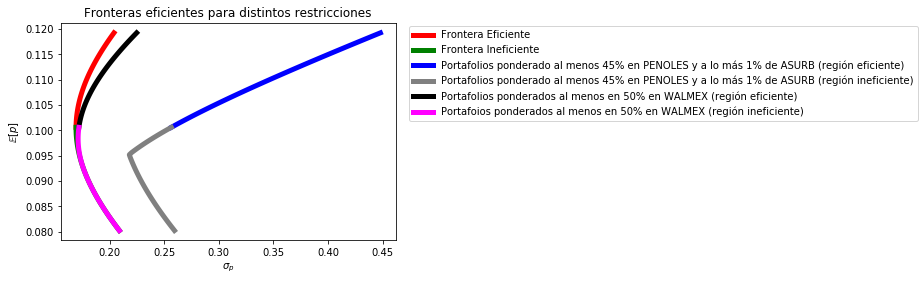

In [75]:
rango_fronteraEf=np.linspace(rend_sim[ds_sim.index(min(ds_sim))],max(rend_sim),50)
rango_fronteraInEf=np.linspace(min(rend_sim),rend_sim[ds_sim.index(min(ds_sim))],50)
pesos_fronteraEf=[]
pesos_fronteraInEf=[]
pesos_restEf1=[]
pesos_restEf2=[]
pesos_restInEf1=[]
pesos_restInEf2=[]
e4=np.zeros(c)
e4[-1]=1
e3=np.zeros(c)
e3[2]=1
e3[0]=-1
rest2=np.zeros(c)
rest2[2]=-0.45
rest2[0]=0.01

for e in rango_fronteraEf:
    constrains2=[{"type":"eq","fun":sum_w},{"type":"eq","fun":lambda w:rend_esp(w,e)}]
    port1=minimize(ds_port,x0=w_sim[ds_sim.index(min(ds_sim))],constraints=constrains2,args=rend)
    pesos_fronteraEf.append(port1.x)

for e in rango_fronteraEf:
    constrains2=[{"type":"eq","fun":sum_w},{"type":"eq","fun":lambda w:rend_esp(w,e)},{"type":"ineq","fun":lambda w:w*e3+rest2}]
    port1=minimize(ds_port,x0=w_sim[ds_sim.index(min(ds_sim))],constraints=constrains2,args=rend)
    pesos_restEf1.append(port1.x)

for e in rango_fronteraEf:
    constrains2=[{"type":"eq","fun":sum_w},{"type":"eq","fun":lambda w:rend_esp(w,e)},{"type":"ineq","fun":lambda w:w*e4-0.5*e4}]
    port1=minimize(ds_port,x0=w_sim[ds_sim.index(min(ds_sim))],constraints=constrains2,args=rend)
    pesos_restEf2.append(port1.x)

for e in rango_fronteraInEf:
    constrains2=[{"type":"eq","fun":sum_w},{"type":"eq","fun":lambda w:rend_esp(w,e)}]
    port1=minimize(ds_port,x0=w_sim[ds_sim.index(min(ds_sim))],constraints=constrains2,args=rend)
    pesos_fronteraInEf.append(port1.x)
    
for e in rango_fronteraInEf:
    constrains2=[{"type":"eq","fun":sum_w},{"type":"eq","fun":lambda w:rend_esp(w,e)},{"type":"ineq","fun":lambda w:w*e3+rest2}]
    port1=minimize(ds_port,x0=w_sim[ds_sim.index(min(ds_sim))],constraints=constrains2,args=rend)
    pesos_restInEf1.append(port1.x)

for e in rango_fronteraInEf:
    constrains2=[{"type":"eq","fun":sum_w},{"type":"eq","fun":lambda w:rend_esp(w,e)},{"type":"ineq","fun":lambda w:w*e4-0.5*e4}]
    port1=minimize(ds_port,x0=w_sim[ds_sim.index(min(ds_sim))],constraints=constrains2,args=rend)
    pesos_restInEf2.append(port1.x)

#Fronteras que maximizan el Sharpe ratio
dominio_fronteraEf=[ds_port(p,rend) for p in pesos_fronteraEf]
dominio_fronteraInEf=[ds_port(p,rend) for p in pesos_fronteraInEf]
#Fronteras que maximizan el Sharpe ratio y con al menos 30% en PENOLES y a lo más 5% de ASURB
dominio_Ef_rest1=[ds_port(p,rend) for p in pesos_restEf1]
dominio_InEf_rest1=[ds_port(p,rend) for p in pesos_restInEf1]
#Fronteras de portafolios que maximizan el Sharpe ratio y que además están ponderados en más del 50% en WALMEX* MF Equity 
dominio_Ef_rest2=[ds_port(p,rend) for p in pesos_restEf2]
dominio_InEf_rest2=[ds_port(p,rend) for p in pesos_restInEf2]

plt.plot(dominio_fronteraEf,rango_fronteraEf,color="red",linewidth=5,label="Frontera Eficiente")
plt.plot(dominio_fronteraInEf,rango_fronteraInEf,color="green",linewidth=5,label="Frontera Ineficiente")

plt.plot(dominio_Ef_rest1,rango_fronteraEf,color="blue",linewidth=5,label="Portafolios ponderado al menos 45% en PENOLES y a lo más 1% de ASURB (región eficiente)")
plt.plot(dominio_InEf_rest1,rango_fronteraInEf,color="gray",linewidth=5,label="Portafolios ponderado al menos 45% en PENOLES y a lo más 1% de ASURB (región ineficiente)")

plt.plot(dominio_Ef_rest2,rango_fronteraEf,color="black",linewidth=5,label="Portafolios ponderados al menos en 50% en WALMEX (región eficiente)")
plt.plot(dominio_InEf_rest2,rango_fronteraInEf,color="magenta",linewidth=5,label="Portafoios ponderados al menos en 50% en WALMEX (región ineficiente)")

plt.title("Fronteras eficientes para distintos restricciones")
plt.ylabel('$\mathbb{E}[p]$')
plt.xlabel('$\sigma_p$')
plt.legend(loc='lower center',bbox_to_anchor =(1.8,.525))
plt.show()

## Graficación

Unamos el universo de portafolios con la región eficiente que maximiza el radio de Sharpe

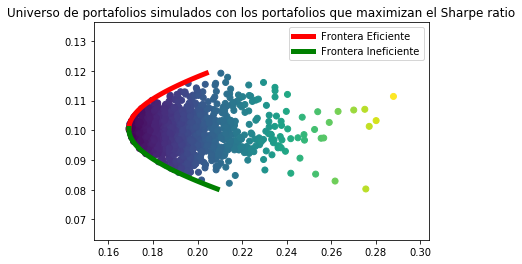

In [77]:
rend=rends.iloc[:,:-1]
np.random.seed(12345)
f,c=rend.shape
n_sim=1000
w_sim=np.random.rand(n_sim,c)

for i in range(n_sim):
    w_sim[i]=w_sim[i]/sum(w_sim[i])

rend_sim=[mean_port(W,rend) for W in w_sim]
ds_sim=[ds_port(W,rend) for W in w_sim]
plt.scatter(ds_sim,rend_sim,c=ds_sim, cmap='viridis')
plt.plot(dominio_fronteraEf,rango_fronteraEf,color="red",linewidth=5,label="Frontera Eficiente")
plt.plot(dominio_fronteraInEf,rango_fronteraInEf,color="green",linewidth=5,label="Frontera Ineficiente")
plt.title('Universo de portafolios simulados con los portafolios que maximizan el Sharpe ratio')
plt.legend()
plt.show()